In [1]:
import os
import sys
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from keras.losses import mean_squared_error, mean_absolute_error, binary_crossentropy

def huber_loss(y_true, y_pred, delta=1.345):
  x = K.abs(y_true - y_pred)
  squared_loss = 0.5*K.square(x)
  absolute_loss = delta * (x - 0.5*delta)
  xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
  return K.mean(xx, axis=-1)

def weighted_crossentropy(target, output, pos_weight, from_logits=False):
    # Note: tf.nn.sigmoid_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    if not from_logits:
      # transform back to logits
      _epsilon = tf.convert_to_tensor(K.epsilon(), dtype=output.dtype.base_dtype)
      output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
      output = tf.log(output / (1 - output))
    return tf.nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=pos_weight)

def my_binary_crossentropy(y_true, y_pred, mask_value=100., pos_weight=0.333333):
  #xx = K.binary_crossentropy(y_true, y_pred)
  xx = weighted_crossentropy(y_true, y_pred, pos_weight=pos_weight) * 2/(1+pos_weight)
  return K.mean(xx, axis=-1)

In [3]:
# Prepare data
n = 126029

# Random numbers between -0.5 and 0.5
y_true = -0.5 + np.random.rand(n)

# d(q/pT) ~ 0.02
y_meas = 0.02 * np.random.randn(n)
y_meas += y_true

reg_pt_scale = 100.
y_true_1 = y_true * reg_pt_scale
y_meas_1 = y_meas * reg_pt_scale

print y_true.shape, y_meas.shape, y_true[:10], y_meas[:10]

(126029,) (126029,) [ 0.23952361 -0.29370959  0.20667369 -0.13100029 -0.47515996 -0.14322074
  0.23890193 -0.11153751 -0.32270488 -0.07737806] [ 0.22780372 -0.3114585   0.22391933 -0.14102887 -0.49799881 -0.1615066
  0.23175032 -0.12763292 -0.34483598 -0.1143619 ]


In [4]:
# Find losses
sess = K.get_session()

loss1 = mean_squared_error(y_true[:,np.newaxis], y_meas[:,np.newaxis]).eval(session=sess)
loss2 = mean_absolute_error(y_true[:,np.newaxis], y_meas[:,np.newaxis]).eval(session=sess)
loss3 = huber_loss(y_true[:,np.newaxis], y_meas[:,np.newaxis]).eval(session=sess)
loss4 = huber_loss(y_true_1[:,np.newaxis], y_meas_1[:,np.newaxis], delta=1.345*2).eval(session=sess)

In [5]:
# Styling
plt.style.use('tdrstyle.mplstyle')

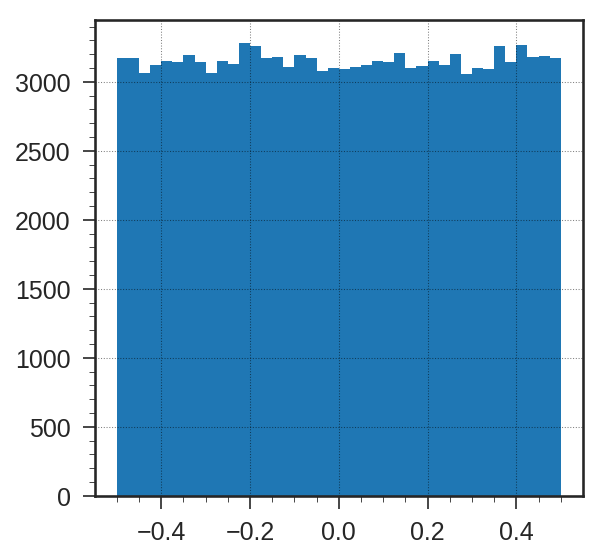

In [6]:
plt.figure()

#plt.hist(np.random.randn(n), bins=40)
plt.hist(y_true, bins=40)

plt.show()

gaus fit (a, mu, sig): [1.25602929e+04 7.23040729e-05 2.00032144e-02]


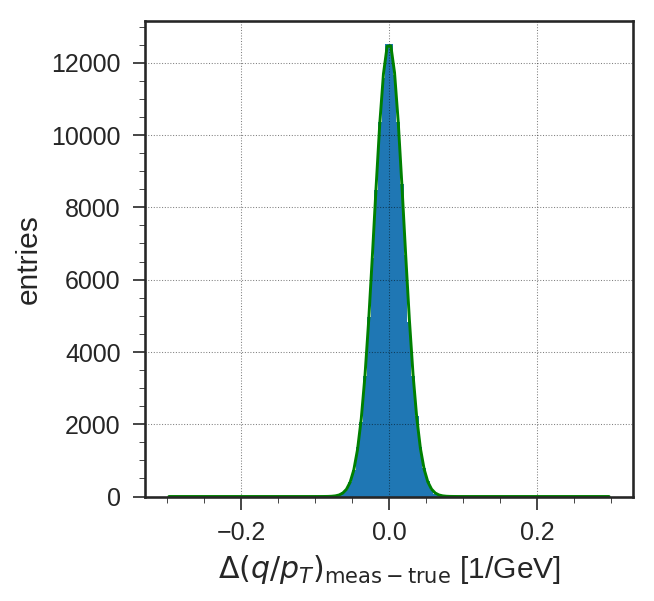

In [7]:
plt.figure()

diff = y_true - y_meas

hist, edges, _ = plt.hist(diff, bins=120, range=(-0.3,0.3))
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')

from scipy.optimize import curve_fit

def gaus(x,a,mu,sig):
  return a*np.exp(-0.5*np.square((x-mu)/sig))

def fit_gaus(hist, edges, mu=0., sig=1.):
  hist = hist.astype('float64')
  edges = edges.astype('float64')
  xdata = (edges[1:] + edges[:-1])/2
  ydata = hist
  popt, pcov = curve_fit(gaus, xdata, ydata, p0=[np.max(hist),mu,sig])
  if not np.isfinite(pcov).all():
    raise Exception('Fit has failed to converge.')
  return popt

popt = fit_gaus(hist, edges, mu=0, sig=0.2)
print('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')

plt.show()

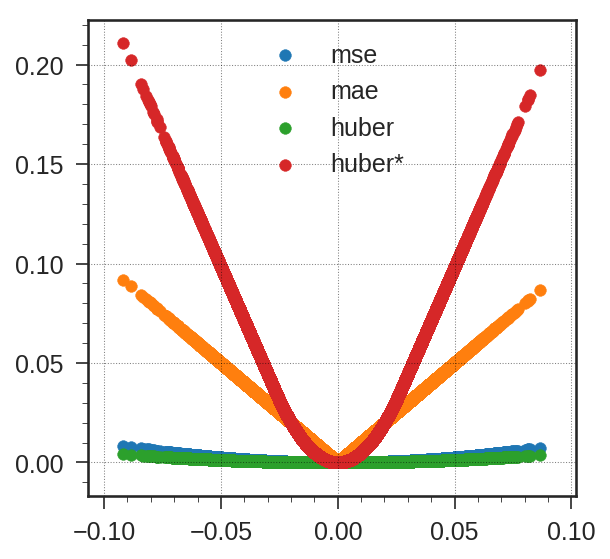

In [8]:
plt.figure()

plt.scatter(diff, loss1)
plt.scatter(diff, loss2)
plt.scatter(diff, loss3)
plt.scatter(diff, loss4/100)

plt.legend(['mse', 'mae', 'huber', 'huber*'])
plt.show()

In [9]:
# Find binary crossentropy losses
z0 = np.zeros(n)
z1 = np.ones(n)
z = np.random.rand(n)

z0 = K.cast(z0, dtype=np.float32)
z1 = K.cast(z1, dtype=np.float32)
z = K.cast(z, dtype=np.float32)

zloss1 = binary_crossentropy(z0[:,np.newaxis], z[:,np.newaxis]).eval(session=sess)
zloss2 = binary_crossentropy(z1[:,np.newaxis], z[:,np.newaxis]).eval(session=sess)
zloss3 = my_binary_crossentropy(z0[:,np.newaxis], z[:,np.newaxis]).eval(session=sess)
zloss4 = my_binary_crossentropy(z1[:,np.newaxis], z[:,np.newaxis]).eval(session=sess)

z0 = z0.eval(session=sess)
z1 = z1.eval(session=sess)
z = z.eval(session=sess)

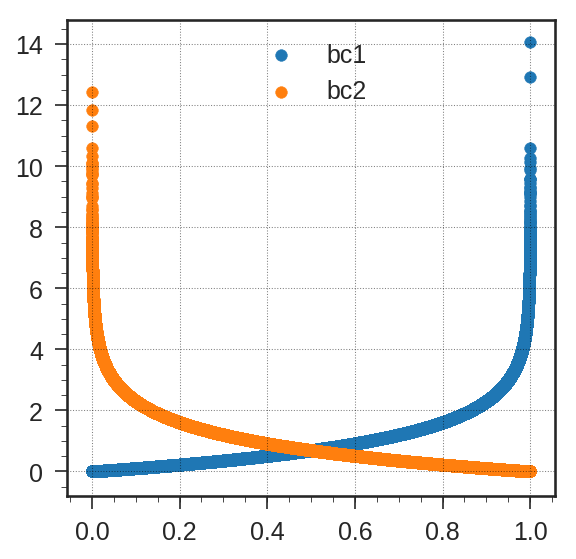

In [10]:
plt.figure()

plt.scatter(z, zloss1)
plt.scatter(z, zloss2)
#plt.scatter(z, zloss3)
#plt.scatter(z, zloss4)

plt.legend(['bc1', 'bc2', 'bc3', 'bc4'])
plt.show()

In [21]:
# Find custom log losses
y_true_2 = y_true * 100
y_meas_2 = y_true * 100

def log_loss1(y_true, y_pred):
  discr_pt_cut = 14.
  reg_pt_scale = 100.
  log_loss_weight = 1
  
  # Use y = 1
  # Sigmoid: 1/(1+e^(-x))
  # Negative log of sigmoid: log(1+e^(-x))
  x_pu = K.abs(y_pred) - reg_pt_scale/discr_pt_cut
  log_loss = K.log(1+K.exp(-x_pu))
  return K.mean(log_loss, axis=-1)

def log_loss2(y_true, y_pred):
  discr_pt_cut = 14.
  reg_pt_scale = 100.
  log_loss_weight = 1
  
  # Use y = 0
  # Sigmoid: 1/(1+e^(-x))
  # 1-sigmoid: 1/(1+e^x)
  # Negative log of 1-sigmoid: log(1+e^(x)) = x + log(1+e^(-x))
  x_pu = K.abs(reg_pt_scale/y_pred) - discr_pt_cut
  x_pu = K.clip(x_pu, 0, 1000)
  log_loss = x_pu + K.log(1+K.exp(-x_pu))
  log_loss_weight = 0.01
  log_loss *= log_loss_weight
  return K.mean(log_loss, axis=-1)

lloss1 = log_loss1(y_true_2[:,np.newaxis], y_meas_2[:,np.newaxis]).eval(session=sess)
lloss2 = log_loss2(y_true_2[:,np.newaxis], y_meas_2[:,np.newaxis]).eval(session=sess)

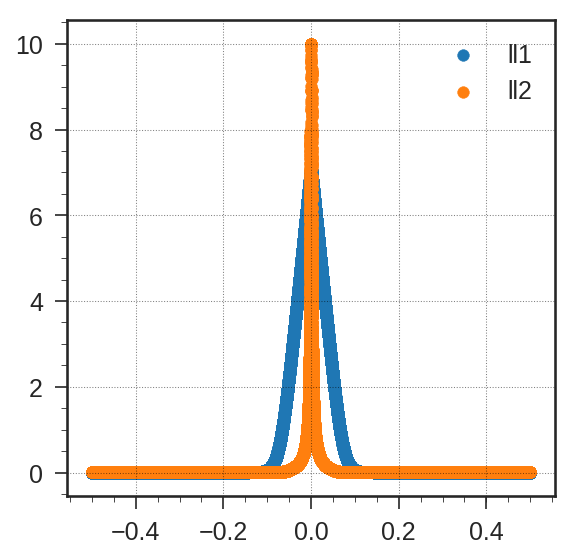

In [22]:
plt.figure()

plt.scatter(y_true, lloss1)
plt.scatter(y_true, lloss2)

plt.legend(['ll1', 'll2', 'll3', 'll4'])
plt.show()